In [1]:
import pandas as pd

import keras
from keras import layers
import keras.backend
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from keras import models
import keras.utils

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

## Import data:
Using jetImages_signal.npz and jetImages_bkg.npz to train the neural network and using jetImages_signal_test.npz and jetImages_bkg_test.npz for testing.

In [2]:
grid = 16
data_train = np.load('data/jetImagesTrain1.npz')
data_test = np.load('data/jetImagesTest1.npz')
feat_all = [key for key in data_train.keys()]
feat_all.remove('labels')

Build DNN:

In [3]:
def build_model():
    input1 = layers.Input(shape = (grid, grid, 1), name = 'input')
    x = layers.Conv2D(32, (5, 5), activation='relu', name = "conv1", padding = 'same')(input1)
    x = layers.Conv2D(32, (3, 3), activation='relu', name = 'conv2', padding = 'same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', name = 'conv3', padding = 'same')(x)
    x = layers.MaxPool2D((2, 2), name = 'maxpool1')(x)
    x = layers.Flatten(name = 'flatten')(x)
    x = layers.Dense(64, activation='relu', name = 'dense1')(x)
    output = layers.Dense(2, activation='softmax', name = 'output')(x)
    model = models.Model(inputs= [input1],
                         outputs = output)
    opt=keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['binary_crossentropy', 'accuracy'])
    return model

Initialize model:

In [4]:
def build_XY(features,label,dic):
    X = [dic[key] for key in features]
    Y = [dic[key] for key in label]
    return X,Y
features = ['jetImages']
X_train, Y_train = build_XY(features,['labels'],data_train)
X_test, Y_test = build_XY(features,['labels'],data_test)
# CNN = build_model()

Test model's prediction $before$ training:

In [5]:
# X_batch = [ele[:10] for ele in X_train]
# Y_batch = [ele[:10] for ele in Y_train]
# example_result = CNN.predict(x = X_batch)
# results = CNN.evaluate(x = X_batch, y = Y_batch )
# print(results)

In [6]:
# X_batch = [ele for ele in X_train]
# Y_batch = [ele for ele in Y_train]
# X_batch_test = [ele for ele in X_test]
# Y_batch_test = [ele for ele in Y_test]

Now train! (warning: if building CNN, computer tends to get loud)

In [7]:
# if not os.path.exists("model"):
#     os.mkdir("model")
# checkpoint_path = "model/CNN2D_3.h5"
# model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
#                                    verbose=1, save_best_only=True, 
#                                    save_weights_only=False, mode='auto', 
#                                    period=1)    
# EPOCHS = 100
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# history = CNN.fit(
#   X_batch, Y_batch,
#   epochs=EPOCHS, validation_split = 0.2, verbose = 0,
#   callbacks=[early_stop, model_checkpoint])

In [8]:
# def plot_history(history):
#     hist = pd.DataFrame(history.history)
#     print(hist.keys())
#     hist['epoch'] = history.epoch
#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.plot(hist['epoch'], hist['loss'],
#            label='Train Error')
#     plt.plot(hist['epoch'], hist['val_loss'],
#            label = 'Val Error')
#     plt.legend()
#     plt.show()

# plot_history(history)

Load best weights.

In [9]:
best_model = keras.models.load_model('model/CNN2D_3.h5')
best_model.summary()
# results = best_model.evaluate(X_batch_test, Y_batch_test, verbose = 0)
# print(results)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16, 16, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 32)        9248      
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 32)        9248      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
______________________

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

In [10]:
# # Plot ROC
# predict = best_model.predict(X_batch_test)
# from sklearn.metrics import roc_curve, auc
# fpr, tpr, thresholds = roc_curve(Y_batch_test[0][:,1], predict[:,1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, lw=4, color='b', label='auc = %.3f' % (roc_auc))
# plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
# plt.xlim([0, 1.0])
# plt.ylim([0, 1.0])
# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')
# plt.title('Toy 2D CNN ROC')
# plt.legend(loc="lower right")
# plt.show()

In [11]:
# sig_pred = predict[np.argwhere(Y_batch_test[0][:][:,1].squeeze()==1.)].squeeze()
# bkg_pred = predict[np.argwhere(Y_batch_test[0][:][:,1].squeeze()==0.)].squeeze()
# plt.hist([sig_pred[:,1], bkg_pred[:,1]],
#          color = ['blue', 'red'], histtype = 'step', label = ['signal predictions', 'background predictions'])
# plt.legend()
# plt.show()

In [12]:
def build_model():
    input1 = layers.Input(shape = (grid, grid, 1))
    input2 = [layers.Input(shape = (1,)) for i in range(1,5)]
    x = layers.Conv2D(32, (5, 5), activation='relu', name = "conv1", padding = 'same')(input1)
    x = layers.Conv2D(32, (3, 3), activation='relu', name = 'conv2', padding = 'same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', name = 'conv3', padding = 'same')(x)
    x = layers.MaxPool2D((2, 2), name = 'maxpool1')(x)
    x1 = layers.Flatten()(x)
    x = layers.concatenate(inputs = [x1] + input2, axis = -1)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inputs= [input1] + input2,
                         outputs = output)
    opt=keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['binary_crossentropy', 'accuracy'])
    return model

In [13]:
features = [key for key in data_train.keys()];features.remove('labels');features
X_train, Y_train = build_XY(features,['labels'],data_train)
print(X_train[1].shape)
X_test, Y_test = build_XY(features,['labels'],data_test)
CNN_XAUG = build_model()

(1000000,)


In [14]:
X_batch = [ele[:10] for ele in X_train]
print(X_batch[0].shape)
Y_batch = [ele[:10] for ele in Y_train]
example_result = CNN_XAUG.predict(x = X_batch)
results = CNN_XAUG.evaluate(x = X_batch, y = Y_batch )
print(results)

(10, 16, 16, 1)
10/10 [==============================] - 0s 9ms/step
[0.6931425333023071, 0.6931425333023071, 0.6000000238418579]


In [15]:
X_batch = [ele for ele in X_train]
Y_batch = [ele for ele in Y_train]
X_batch_test = [ele for ele in X_test]
Y_batch_test = [ele for ele in Y_test]

In [16]:
checkpoint_path = "model/CNN2D_XAUG_2.h5"
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    
EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1.0e-5)
history = CNN_XAUG.fit(
  X_batch, Y_batch,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[early_stop, model_checkpoint])


Epoch 00001: val_loss improved from inf to 0.00865, saving model to model/CNN2D_XAUG_2.h5

Epoch 00002: val_loss improved from 0.00865 to 0.00662, saving model to model/CNN2D_XAUG_2.h5

Epoch 00003: val_loss improved from 0.00662 to 0.00638, saving model to model/CNN2D_XAUG_2.h5

Epoch 00004: val_loss improved from 0.00638 to 0.00635, saving model to model/CNN2D_XAUG_2.h5

Epoch 00005: val_loss improved from 0.00635 to 0.00607, saving model to model/CNN2D_XAUG_2.h5

Epoch 00006: val_loss did not improve from 0.00607

Epoch 00007: val_loss did not improve from 0.00607

Epoch 00008: val_loss did not improve from 0.00607

Epoch 00009: val_loss did not improve from 0.00607

Epoch 00010: val_loss did not improve from 0.00607


Index(['val_loss', 'val_binary_crossentropy', 'val_acc', 'loss',
       'binary_crossentropy', 'acc'],
      dtype='object')


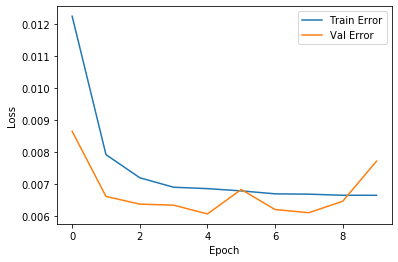

In [17]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    print(hist.keys())
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.legend()
    plt.show()

plot_history(history)

In [18]:
best_model = keras.models.load_model('model/CNN2D_XAUG.h5')
best_model.summary()
results = best_model.evaluate(X_batch_test, Y_batch_test[0], verbose = 0)
print(results)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 16, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 16, 16, 32)   9248        conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 16, 16, 32)   9248        conv2[0][0]                      
__________________________________________________________________________________________________
maxpool1 (

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 4 array(s), but instead got the following list of 5 arrays: [array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
    ...

In [ ]:
# Plot ROC
predict = best_model.predict(X_batch_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_batch_test[0][:][:,1], predict[:][:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=4, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Toy 2D CNN ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
sig_pred = predict[np.argwhere(Y_batch_test[0][:,1].squeeze()==1.)].squeeze()
print(sig_pred)
bkg_pred = predict[np.argwhere(Y_batch_test[0][:,1].squeeze()==0.)].squeeze()
plt.hist([sig_pred[:,1], bkg_pred[:,1]],
         color = ['blue', 'red'], histtype = 'step', label = ['signal predictions', 'background predictions'])
plt.legend()
plt.show()